In [ ]:
from importdata import data
from fft import *
from mobility import *
from permutationentropy import *
from utils import *
from lempelziv import *
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from parameters import *

import matplotlib.pyplot as plt


The BIS data is universally longer than the corresponding EEG data. 
It is assumed that the recording of the BIS data continued after the recording of the EEG data has stopped.
This cell trims the BIS data accordingly.

In [ ]:
for case in data:
    eeg_duration = case['EEG'].shape[1]/sampling_rate
    bis_duration = case['bis'].shape[1]/bis_sampling_rate
    difference = bis_duration - eeg_duration
    trim_length = int(round(difference * bis_sampling_rate))
    case['bis'] = case['bis'][:, :trim_length + 1]
    bis_duration = case['bis'].shape[1]/bis_sampling_rate



In [ ]:
train_data = data[::2] #select every second case for training
test_data = data[1::2] #select every other case for testing

    
eeg_train_data = [case['EEG'] for case in train_data]
bis_train_data = [case['bis'] for case in train_data]

eeg_test_data = [case['EEG'] for case in test_data]
bis_test_data = [case['bis'] for case in train_data]

signal_lengths = [len(case[0]) for case in eeg_train_data] 


In [ ]:
count = 0
for case in train_data:
    for value in case['bis'][0]:
        count += 1

print(count)


In [ ]:
decomposed_eeg_train_data = [fft(case, sampling_rate) for case in eeg_train_data] #returns an array where each element represents a case and each case is a dictionary where the keys are frequency bands and the values are in the frequency domain
decomposed_eeg_train_time_domain = convert_decomposed_to_time_domain(decomposed_eeg_train_data) #the same as above except the values are in the time domain
decomposed_eeg_train_time_domain_power = convert_decomposed_amplitude_to_power(decomposed_eeg_train_time_domain) #the same as above except the values represent power rather than amplitude

decomposed_eeg_test_data = [fft(case, sampling_rate) for case in eeg_test_data]
decomposed_eeg_test_time_domain = convert_decomposed_to_time_domain(decomposed_eeg_test_data)
decomposed_eeg_test_time_domain_power = convert_decomposed_amplitude_to_power(decomposed_eeg_test_time_domain)

In [6]:
mobility_amplitude_array_train = operation_on_multiple_case_data(decomposed_eeg_train_time_domain, calculate_mobility, sampling_rate, signal_lengths, mobility_window_duration, mobility_overlap_fraction)
pe_amplitude_array_train = operation_on_multiple_case_data(decomposed_eeg_train_time_domain, PE, sampling_rate, signal_lengths, complexity_features_window, complexity_features_overlap)
lzc_amplitude_array_train = operation_on_multiple_case_data(decomposed_eeg_train_time_domain, LZC_single_band, sampling_rate, signal_lengths, complexity_features_window, complexity_features_overlap)

mobility_power_array_train = operation_on_multiple_case_data(decomposed_eeg_train_time_domain_power, calculate_mobility, sampling_rate, signal_lengths, mobility_window_duration, mobility_overlap_fraction)
pe_power_array_train = operation_on_multiple_case_data(decomposed_eeg_train_time_domain_power, PE, sampling_rate, signal_lengths, complexity_features_window, complexity_features_overlap)
lzc_power_array_train = operation_on_multiple_case_data(decomposed_eeg_train_time_domain_power, LZC_single_band, sampling_rate, signal_lengths, complexity_features_window, complexity_features_overlap)

In [ ]:
mobility_amplitude_bis_train_dict = associate_features_with_BIS(mobility_amplitude_array_train, bis_train_data, mobility_window_duration, mobility_overlap_fraction, bis_sampling_rate)
mobility_amplitude_train_r2 = linear_regression(mobility_amplitude_bis_train_dict)
print(f'mobility amplitude train r2{mobility_amplitude_train_r2}')

mobility_power_bis_train_dict = associate_features_with_BIS(mobility_power_array_train, bis_train_data, mobility_window_duration, mobility_overlap_fraction, bis_sampling_rate)
mobility_power_train_r2 = linear_regression(mobility_power_bis_train_dict)
print(f'mobility power train r2{mobility_power_train_r2}')

pe_amplitude_bis_train_dict = associate_features_with_BIS(pe_amplitude_array_train, bis_train_data, complexity_features_window, complexity_features_overlap, bis_sampling_rate)
pe_amplitude_train_r2 = linear_regression(pe_amplitude_bis_train_dict)
print(f'pe amplitude train r2{pe_amplitude_train_r2}')

pe_power_bis_train_dict = associate_features_with_BIS(pe_power_array_train, bis_train_data, complexity_features_window, complexity_features_overlap, bis_sampling_rate)
pe_power_train_r2 = linear_regression(pe_power_bis_train_dict)
print(f'pe power train r2 {pe_power_train_r2}')

lzc_amplitude_bis_train_dict = associate_features_with_BIS(lzc_amplitude_array_train, bis_train_data, complexity_features_window, complexity_features_overlap, bis_sampling_rate)
lzc_amplitude_train_r2 = linear_regression(lzc_amplitude_bis_train_dict)
print(f'lzc amplitude train r2 {lzc_amplitude_train_r2}')

lzc_power_bis_train_dict = associate_features_with_BIS(lzc_power_array_train, bis_train_data, complexity_features_window, complexity_features_overlap, bis_sampling_rate)
lzc_power_train_r2 = linear_regression(lzc_power_bis_train_dict)
print(f'lzc power train r2 {lzc_power_train_r2}')



Text(0.5, 1.0, 'Mobility')

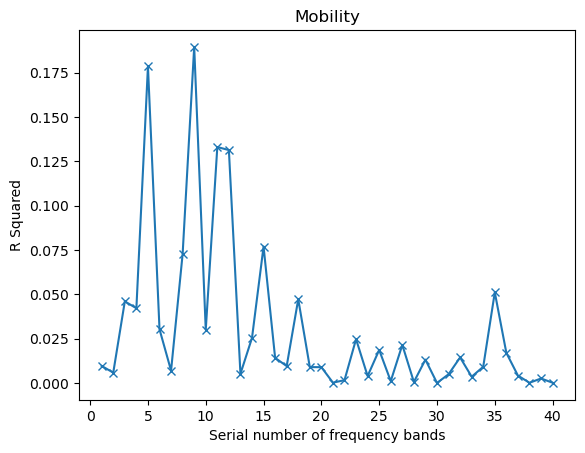

In [8]:
r2_mobility = list(mobility_amplitude_train_r2.values()) + list(mobility_power_train_r2.values())
frequency_bands_mobility = list(range(1, len(r2_mobility) + 1))

plt.plot(frequency_bands_mobility, r2_mobility, marker = 'x')

plt.xlabel("Serial number of frequency bands")
plt.ylabel("R Squared")
plt.title("Mobility")





Text(0.5, 1.0, 'Permutation Entropy')

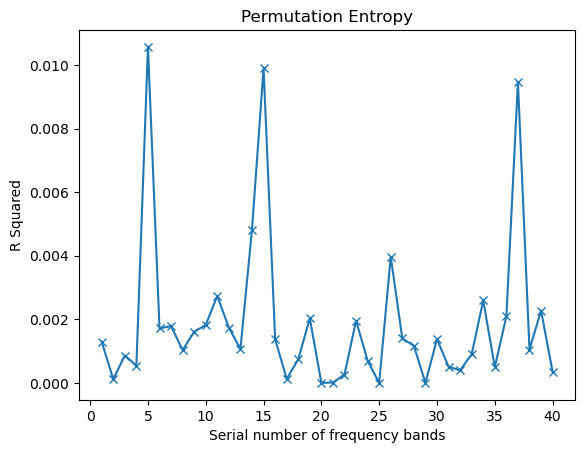

In [9]:
r2_pe = list(pe_amplitude_train_r2.values()) + list(pe_power_train_r2.values())
frequency_bands_pe = list(range(1, len(r2_pe) + 1))

plt.plot(frequency_bands_pe, r2_pe, marker = 'x')

plt.xlabel("Serial number of frequency bands")
plt.ylabel("R Squared")
plt.title("Permutation Entropy")

Text(0.5, 1.0, 'Lempel-Ziv Complexity')

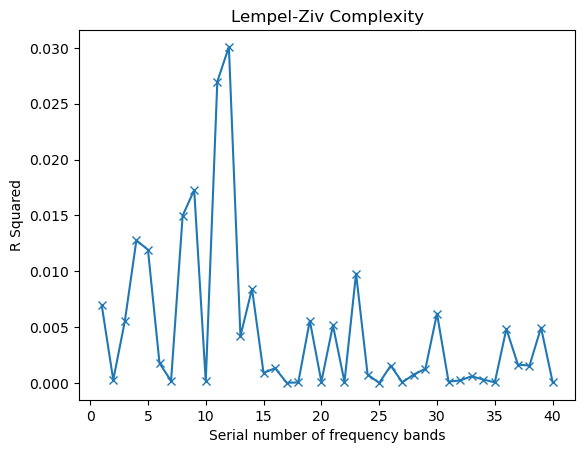

In [10]:
r2_lzc = list(lzc_amplitude_train_r2.values()) + list(lzc_power_train_r2.values())
frequency_bands_lzc = list(range(1, len(r2_lzc) + 1))

plt.plot(frequency_bands_lzc, r2_lzc, marker = 'x')

plt.xlabel("Serial number of frequency bands")
plt.ylabel("R Squared")
plt.title("Lempel-Ziv Complexity")